In [1]:
import random
import pandas as pd
import numpy as np
from brainiak.fcma.util import compute_correlation
import os, pickle, glob, configparser
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import nibabel as nib
from nilearn import plotting, surface
import nibabel as nib



sub_list = range(1,9)
exp_config = configparser.ConfigParser()
exp_config.read('../config')


# Set the directories
NSD_top_dir = exp_config['DIR']['NSD_top_dir']
vis_mask_dir = os.path.join(NSD_top_dir, 
                            'intermediate', 
                            'masks', 
                            'grouped_visual_ROIs')
rs_dir = os.path.join(NSD_top_dir, 
                            'intermediate', 
                            'resting_state')
mask_output_dir = os.path.join(NSD_top_dir, 
                               'intermediate',
                               'masks', 
                               'HCP_MMP_ROIs')

In [2]:
all_subs_mean_conn = []
all_subs_mean_conn_norm = []
verts_labels = []

sub_lookup = []
hemi_labels = []


for curr_sub in sub_list:
    lh_file_list = glob.glob(os.path.join(rs_dir,
                                        'subj0{}'.format(curr_sub),
                                       'lh.*_run1.npy'))
    sampled_ses = [k.split('session')[1][:2] for k in lh_file_list]

    visual_rois = pickle.load(open(os.path.join(vis_mask_dir, 'sub0{}.visualROIs'.format(curr_sub)), 'rb'))
    print(len(visual_rois))
    lh_frontal_mask = np.load(os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.npy'.format(curr_sub)))
    rh_frontal_mask = np.load(os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.npy'.format(curr_sub)))

    # Calculate connectivity profiles
    sampled_conn_profs = []
    sampled_conn_profs_norm = []
    for curr_ses in sampled_ses:
        #print(curr_ses)
        lh_rs_dir = os.path.join(rs_dir,
                                'subj0{}'.format(curr_sub),
                                'lh.session{}_run1.npy'.format(curr_ses))
        rh_rs_dir = os.path.join(rs_dir,
                                'subj0{}'.format(curr_sub),
                                'rh.session{}_run1.npy'.format(curr_ses))
        lh_ts = np.load(lh_rs_dir)
        rh_ts = np.load(rh_rs_dir)

        visual_ts = np.zeros((len(visual_rois), lh_ts.shape[1]))

        # Extract timeseries from the visual ROIs
        
        for curr_key_ind, curr_key in enumerate(visual_rois.keys()):
            if curr_key[:2] == 'lh':
                curr_roi_ts = np.mean(lh_ts[visual_rois[curr_key], :], axis=0)
            elif curr_key[:2] == 'rh':
                curr_roi_ts = np.mean(rh_ts[visual_rois[curr_key], :], axis=0)
            visual_ts[curr_key_ind, :] = curr_roi_ts

        # Extract timeseries from the frontal ROIs
        lh_frontal_ts = lh_ts[lh_frontal_mask, :]
        rh_frontal_ts = rh_ts[rh_frontal_mask, :]

        both_hemi_ts = np.vstack((lh_frontal_ts, rh_frontal_ts))
        both_hemi_conn = compute_correlation(both_hemi_ts, visual_ts)
        both_hemi_conn_norm = stats.zscore(np.arctanh(both_hemi_conn))
        sampled_conn_profs.append(both_hemi_conn)
        sampled_conn_profs_norm.append(both_hemi_conn_norm)
        
    # Compute the averge connectivity mat
    for count in range(len(sampled_conn_profs)):
        if count == 0:
            mean_train_conn = sampled_conn_profs[count]
            mean_train_conn_norm = sampled_conn_profs_norm[count]
        else:
            mean_train_conn = mean_train_conn + sampled_conn_profs[count]
            mean_train_conn_norm = mean_train_conn_norm + sampled_conn_profs_norm[count]
            
    mean_train_conn = mean_train_conn / len(sampled_conn_profs)
    mean_train_conn_norm = mean_train_conn_norm / len(sampled_conn_profs)

    
    sub_labels = curr_sub*np.ones((mean_train_conn.shape[0],1))
    
    all_subs_mean_conn.append(mean_train_conn)
    all_subs_mean_conn_norm.append(mean_train_conn_norm)
    
    sub_lookup = sub_lookup + [sub_labels]
    
    lh_hemi_label = np.ones((lh_frontal_ts.shape[0], 1))
    rh_hemi_label = 2*np.ones((rh_frontal_ts.shape[0], 1))
    both_hemi_label = np.vstack((lh_hemi_label, rh_hemi_label))
    hemi_labels.append(both_hemi_label)
    verts_labels.append(np.array(range(mean_train_conn.shape[0])))

68
68
68
68
68
68
68
68


In [3]:
for ind, k in enumerate(sub_lookup):
    if ind == 0:
        sub_label_array = k
    else:
        sub_label_array = np.vstack((sub_label_array, k))
        
for ind, k in enumerate(hemi_labels):
    if ind == 0:
        hemi_label_array = k
    else:
        hemi_label_array = np.vstack((hemi_label_array, k))
        
for ind, k in enumerate(verts_labels):
    if ind == 0:
        vert_label_array = np.expand_dims(k, axis=-1)
    else:
        vert_label_array = np.vstack((vert_label_array, np.expand_dims(k, axis=-1)))

for count, curr_sub_conn in enumerate(all_subs_mean_conn):
    if count == 0:
        mega_sub_conn = curr_sub_conn
    else:
        mega_sub_conn = np.vstack((mega_sub_conn, curr_sub_conn))

for count, curr_sub_conn_norm in enumerate(all_subs_mean_conn_norm):
    if count == 0:
        mega_sub_conn_norm = curr_sub_conn_norm
    else:
        mega_sub_conn_norm = np.vstack((mega_sub_conn_norm, curr_sub_conn_norm))

In [4]:
conn_df = pd.DataFrame(np.mean(mega_sub_conn, axis=1),
                      columns=['Conn'])
conn_df['SUB'] = sub_label_array.squeeze()
conn_df['VERTEX'] = vert_label_array.squeeze()

In [5]:
lPFC_results_dir = os.path.join(NSD_top_dir, 'results', 'CV_results_CLIP')
output_fig_dir = os.path.join(NSD_top_dir, 'figures', 'Manuscript')
for curr_sub in sub_list:
    curr_sub_df_dir = os.path.join(lPFC_results_dir, 'sub0{}_img_GS_norm.csv'.format(curr_sub))
    curr_sub_df = pd.read_csv(curr_sub_df_dir, header=None, names=['SUB', 'VERTEX', 'CV-r', 'best alpha'])
    if curr_sub == 1:
        summary_df = curr_sub_df
    else:
        summary_df = pd.concat([summary_df, curr_sub_df]).reset_index(drop=True)

In [6]:
filtered_summary_df = summary_df[summary_df['CV-r']>0.1]

In [7]:
def group_and_count_verts(mask_vect):
    _df = pd.DataFrame(mask_vect, columns=['roi_ind'])
    _df['count'] = 0
    count_df = _df.groupby(by='roi_ind')['count'].count().reset_index()
    return count_df

In [8]:
def generate_bin_mask(lh_mask, rh_mask, rs_df, variable):
    # Separate the dataframe in to left and righ hemispheres
    lh_rs_df = rs_df[rs_df['VERTEX']<np.sum(lh_mask)]
    rh_rs_df = rs_df[rs_df['VERTEX']>=np.sum(lh_mask)]
    rh_rs_df['VERTEX'] = rh_rs_df['VERTEX']-np.sum(lh_mask)
    
    # Fill the values into the masks
    lh_mask_nozero = np.where(lh_mask)
    lh_mask_thresh = np.zeros(lh_mask.shape)
    lh_mask_thresh[:] = np.nan
    lh_mask_thresh[lh_mask_nozero[0][lh_rs_df['VERTEX'].values]] = lh_rs_df[variable].values>0

    rh_mask_nozero = np.where(rh_mask)
    rh_mask_thresh = np.zeros(rh_mask.shape)
    rh_mask_thresh[:] = np.nan
    rh_mask_thresh[rh_mask_nozero[0][rh_rs_df['VERTEX'].values]] = rh_rs_df[variable].values>0
    
    return lh_mask_thresh.astype('>f4'), rh_mask_thresh.astype('>f4')

In [9]:
list_rois = [10, 11, 12] + list(range(67, 91)) + [96, 97, 98] +[170, 171]
for curr_sub in sub_list:
    curr_sub_df = filtered_summary_df[filtered_summary_df['SUB']==curr_sub]
    
    
    native_dir = os.path.join(NSD_top_dir,
                              'data',
                                   'nsddata', 
                                   'freesurfer', 
                                   'subj0{}'.format(curr_sub))
    HCP_MMP_rois_label = pd.read_csv(os.path.join(native_dir,
                                             'label',
                                             'HCP_MMP1.mgz.ctab'),
                                sep=' ', skiprows=1,
                                 names=['index', 'label'])
    list_rois_names = [HCP_MMP_rois_label['label'].values[k-1] for k in list_rois]
    roi_dict = {list_rois[i]: list_rois_names[i] for i in range(len(list_rois))}
    
    
    lh_HCP_MMP_dir = os.path.join(native_dir,
                         'label',
                         'lh.HCP_MMP1.mgz')
    lh_HCP_MMP = nib.load(lh_HCP_MMP_dir).get_fdata().squeeze()
    lh_lPFC_mask = np.load(os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.npy'.format(curr_sub)))
    
    rh_HCP_MMP_dir = os.path.join(native_dir,
                         'label',
                         'rh.HCP_MMP1.mgz')
    rh_HCP_MMP = nib.load(rh_HCP_MMP_dir).get_fdata().squeeze()
    rh_lPFC_mask = np.load(os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.npy'.format(curr_sub)))
    
    # Make binary masks
    lh_bin_lPFC, rh_bin_lPFC = generate_bin_mask(lh_lPFC_mask, rh_lPFC_mask, curr_sub_df, 'CV-r')
    
    # Mask the Glasser atlas with the predictablity mask
    lh_pred_patches = lh_bin_lPFC*lh_HCP_MMP 
    rh_pred_patches = rh_bin_lPFC*rh_HCP_MMP
    
    # Make dfs 
    HCP_MMP_count = group_and_count_verts(np.hstack((lh_HCP_MMP, rh_HCP_MMP)))
    pred_patches_count = group_and_count_verts(np.hstack((lh_pred_patches, rh_pred_patches))).rename(columns={'count': 'pred_count'})
    merge_df = HCP_MMP_count.merge(pred_patches_count)
    merge_df['SUB'] = curr_sub
    merge_df['roi_names'] = merge_df['roi_ind'].map(roi_dict)
    
    # Find out which parcels have > 10% predictable vertices, we want to keep those
    merge_df['prop'] = merge_df['pred_count']/merge_df['count']
    pred_parcels = merge_df[merge_df['prop']>0.1]['roi_ind'].unique()
    
    lh_lPFC_all = lh_HCP_MMP[lh_lPFC_mask]
    rh_lPFC_all = rh_HCP_MMP[rh_lPFC_mask]
    
    lh_verts_num = np.sum(lh_lPFC_mask)
    lh_keep_verts = np.where(np.isin(lh_lPFC_all, pred_parcels))
    rh_keep_verts = np.where(np.isin(rh_lPFC_all, pred_parcels))+lh_verts_num
    curr_pred_parcels_verts = pd.DataFrame(np.hstack((lh_keep_verts[0],
                                                     rh_keep_verts[0])), columns=['VERTEX'])
    curr_pred_parcels_verts['SUB'] = curr_sub
    
    
    if curr_sub == 1:
        pred_parcels_verts = curr_pred_parcels_verts
    else:
        pred_parcels_verts = pd.concat([pred_parcels_verts, curr_pred_parcels_verts]).reset_index(drop=True)

/lustre/home/qilin1/miniforge3/envs/GenPFC_mini/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [10]:
conn_df_w_pred_parcels = conn_df.merge(pred_parcels_verts)

In [11]:
conn_df_w_pred_parcels_CVr = conn_df_w_pred_parcels.merge(filtered_summary_df,
                                                          how='left',
                                                         on=['SUB','VERTEX'])

In [12]:
conn_df_w_pred_parcels_CVr['Predictable?'] = ''
conn_df_w_pred_parcels_CVr.loc[conn_df_w_pred_parcels_CVr['CV-r'].isna(),
                            'Predictable?'] = 'No'
conn_df_w_pred_parcels_CVr.loc[~conn_df_w_pred_parcels_CVr['CV-r'].isna(),
                            'Predictable?'] = 'Yes'

In [13]:
grouped_df = conn_df_w_pred_parcels_CVr.groupby(by=['SUB', 'Predictable?'])['Conn'].mean().reset_index()

In [14]:
grouped_df_yes = grouped_df[grouped_df['Predictable?']=='Yes']
grouped_df_no = grouped_df[grouped_df['Predictable?']=='No']

In [15]:
merged_df = grouped_df_yes.merge(grouped_df_no, on='SUB')

In [16]:
merged_df

,SUB,Predictable?_x,Conn_x,Predictable?_y,Conn_y
0,1.0,Yes,0.021978,No,-0.018723
1,2.0,Yes,0.026716,No,-0.032101
2,3.0,Yes,0.104062,No,-0.018501
3,4.0,Yes,0.071217,No,-0.007834
4,5.0,Yes,0.078264,No,-0.026333
5,6.0,Yes,0.096214,No,-0.029450
6,7.0,Yes,0.092528,No,-0.033474
7,8.0,Yes,0.164812,No,0.021195


In [17]:
stats.wilcoxon(merged_df['Conn_x'], merged_df['Conn_y'], mode='approx')

/lustre/home/qilin1/miniforge3/envs/GenPFC_mini/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.011718685599768628)

In [29]:
print('Predictable vertices: mean = {}, sd = {}'.format(str(merged_df['Conn_x'].mean().round(2)),
                                                     str(merged_df['Conn_x'].std().round(2))))

Predictable vertices: mean = 0.08, sd = 0.05


In [31]:
print('Non-predictable vertices: mean = {}, sd = {}'.format(str(merged_df['Conn_y'].mean().round(2)),
                                                     str(merged_df['Conn_y'].std().round(2))))

Non-predictable vertices: mean = -0.02, sd = 0.02


In [18]:
conn_df_w_pred_parcels_CVr['SUB'] = conn_df_w_pred_parcels_CVr['SUB'].astype(int)

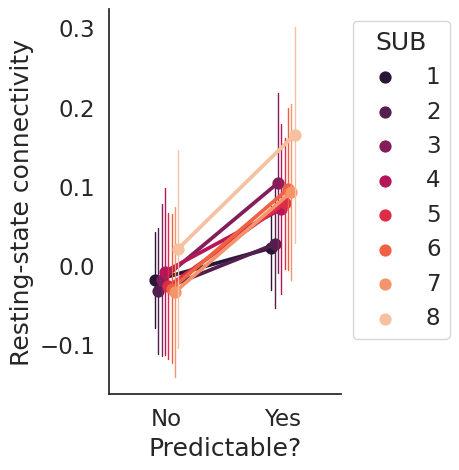

In [19]:
plt.figure(figsize=(3,5))
sns.set(font_scale=1.5)
sns.set_style('white')

ax=sns.pointplot(x='Predictable?', y ='Conn', hue='SUB', errorbar='sd', dodge=True,
                 errwidth=1,
                palette='rocket',
              data=conn_df_w_pred_parcels_CVr)
sns.despine(top=True, right=True)
plt.ylabel('Resting-state connectivity')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(output_fig_dir, 'RS_connectivity.pdf'), dpi=50)

In [20]:
def generate_r_mask(lh_mask, rh_mask, rs_df, variable):
    # Separate the dataframe in to left and righ hemispheres
    lh_rs_df = rs_df[rs_df['VERTEX']<np.sum(lh_mask)]
    rh_rs_df = rs_df[rs_df['VERTEX']>=np.sum(lh_mask)]
    rh_rs_df['VERTEX'] = rh_rs_df['VERTEX']-np.sum(lh_mask)
    
    # Fill the values into the masks
    lh_mask_nozero = np.where(lh_mask)
    lh_mask_thresh = np.zeros(lh_mask.shape)
    lh_mask_thresh[:] = np.nan
    lh_mask_thresh[lh_mask_nozero[0][lh_rs_df['VERTEX'].values]] = lh_rs_df[variable].values

    rh_mask_nozero = np.where(rh_mask)
    rh_mask_thresh = np.zeros(rh_mask.shape)
    rh_mask_thresh[:] = np.nan
    rh_mask_thresh[rh_mask_nozero[0][rh_rs_df['VERTEX'].values]] = rh_rs_df[variable].values
    
    return lh_mask_thresh.astype('>f4'), rh_mask_thresh.astype('>f4')

In [21]:
vmax_curr_layer = conn_df_w_pred_parcels_CVr['Conn'].max()
for curr_sub in sub_list:
    print('Current subject:{}'.format(curr_sub))
    # Put the r values back to the brain
    lh_frontal_mask = np.load(os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.npy'.format(curr_sub)))
    rh_frontal_mask = np.load(os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.npy'.format(curr_sub)))
    print('Number of frontal vertices in lh: {}'.format(np.sum(lh_frontal_mask)))
    print('Number of frontal vertices in rh: {}'.format(np.sum(rh_frontal_mask)))
    print('Number of frontal vertices in total: {}'.format(np.sum(lh_frontal_mask)+np.sum(rh_frontal_mask)))
    
    native_surf_dir = os.path.join(NSD_top_dir,
                                   'data',
                               'nsddata', 
                               'freesurfer', 
                               'subj0{}'.format(curr_sub),
                              'surf')
    infl_right_dir = os.path.join(native_surf_dir, 'rh.inflated')
    sulc_right_dir = os.path.join(native_surf_dir, 'rh.sulc')
    infl_left_dir = os.path.join(native_surf_dir, 'lh.inflated')
    sulc_left_dir = os.path.join(native_surf_dir, 'lh.sulc')
    
    # Plot lPFC outline as contour
    lh_frontal_contour = os.path.join(mask_output_dir, 'lh.lPFC.sub0{}.annot'.format(curr_sub))
    rh_frontal_contour = os.path.join(mask_output_dir, 'rh.lPFC.sub0{}.annot'.format(curr_sub))
    lh_frontal_lPFC = surface.load_surf_data(lh_frontal_contour)
    rh_frontal_lPFC = surface.load_surf_data(rh_frontal_contour)
    
    curr_sub_lh_rs_mask_1, curr_sub_rh_rs_mask_1 = generate_r_mask(lh_frontal_mask,
                                                              rh_frontal_mask,
                                                              conn_df_w_pred_parcels_CVr[conn_df_w_pred_parcels_CVr['SUB']==curr_sub],
                                                              'Conn')

    fig = plotting.plot_surf_stat_map(
        infl_right_dir, curr_sub_rh_rs_mask_1, hemi='right',
        title='Subj0{} (right)'.format(curr_sub), colorbar=True, vmax=vmax_curr_layer,
        bg_map=sulc_right_dir, threshold=0, #cmap='plasma',
    )
    levels = [1]
    labels = ['lPFC']
    
    plotting.plot_surf_contours(
        infl_right_dir, rh_frontal_contour, hemi='right',
        labels=labels, levels=levels,
        bg_map=sulc_right_dir, figure=fig,
        colors=['purple'],
        output_file=os.path.join(output_fig_dir, 'sub0{}_wlPFC_rh_conn.png'.format(curr_sub))
    )

    
    fig.show()
    
    
    fig = plotting.plot_surf_stat_map(
    infl_left_dir, curr_sub_lh_rs_mask_1, hemi='left',
    title='Subj0{} (left)'.format(curr_sub), colorbar=True, vmax=vmax_curr_layer,
    bg_map=sulc_left_dir, threshold=0,#cmap='plasma',
    )
    
    plotting.plot_surf_contours(
        infl_left_dir, lh_frontal_contour, hemi='left',
        labels=labels, levels=levels,
        bg_map=sulc_left_dir, figure=fig,
        colors=['purple'],
        output_file=os.path.join(output_fig_dir, 'sub0{}_wlPFC_lh_conn.png'.format(curr_sub))
    )
    fig.show()
    

Current subject:1
Number of frontal vertices in lh: 41584
Number of frontal vertices in rh: 41844
Number of frontal vertices in total: 83428


/lustre/home/qilin1/miniforge3/envs/GenPFC_mini/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Current subject:2
Number of frontal vertices in lh: 45459
Number of frontal vertices in rh: 46301
Number of frontal vertices in total: 91760
Current subject:3
Number of frontal vertices in lh: 43519
Number of frontal vertices in rh: 43478
Number of frontal vertices in total: 86997
Current subject:4
Number of frontal vertices in lh: 40518
Number of frontal vertices in rh: 39672
Number of frontal vertices in total: 80190
Current subject:5
Number of frontal vertices in lh: 34351
Number of frontal vertices in rh: 35400
Number of frontal vertices in total: 69751
Current subject:6
Number of frontal vertices in lh: 46528
Number of frontal vertices in rh: 46853
Number of frontal vertices in total: 93381
Current subject:7
Number of frontal vertices in lh: 35599
Number of frontal vertices in rh: 36079
Number of frontal vertices in total: 71678
Current subject:8
Number of frontal vertices in lh: 41577
Number of frontal vertices in rh: 43020
Number of frontal vertices in total: 84597
